In [6]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model


In [7]:
metadata  = pd.read_csv("HAM10000_metadata.csv")

In [8]:
print(metadata.head())

     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


Datacleaning

In [9]:
missing_values = metadata.isnull().sum()

missing_percentage = (missing_values / len(metadata)) * 100

missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

missing_summary = missing_summary[missing_summary['Missing Values'] > 0]

print("Missing Vaules:")
print(missing_summary)


Missing Vaules:
     Missing Values  Percentage
age              57    0.569146


In [10]:
metadata_cleaned = metadata.dropna(subset=['age'])


End Datacleaning

In [11]:
categorical_cols = ['sex', 'localization']

metadata = pd.get_dummies(metadata_cleaned, columns=categorical_cols)


In [12]:
label_encoder = LabelEncoder()
metadata['label'] = label_encoder.fit_transform(metadata['dx'])


In [13]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9958 entries, 0 to 10014
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   lesion_id                     9958 non-null   object 
 1   image_id                      9958 non-null   object 
 2   dx                            9958 non-null   object 
 3   dx_type                       9958 non-null   object 
 4   age                           9958 non-null   float64
 5   sex_female                    9958 non-null   bool   
 6   sex_male                      9958 non-null   bool   
 7   sex_unknown                   9958 non-null   bool   
 8   localization_abdomen          9958 non-null   bool   
 9   localization_acral            9958 non-null   bool   
 10  localization_back             9958 non-null   bool   
 11  localization_chest            9958 non-null   bool   
 12  localization_ear              9958 non-null   bool   
 13  localiz

 Loading and pre-processing images

In [14]:

image_folder = './HAM10000_images'

IMAGE_SIZE = (228, 228)

def load_image(image_id):
    image_path = os.path.join(image_folder, image_id + '.jpg')
    try:
        image = Image.open(image_path).resize(IMAGE_SIZE)
        image = np.array(image) / 255.0
        return image
    except:
        return None


In [15]:
metadata['image'] = metadata['image_id'].apply(load_image)

metadata = metadata[metadata['image'].notnull()]


Prepare features and labels

In [16]:
X_images = np.stack(metadata['image'].values)


In [17]:
metadata_features = metadata.drop(['lesion_id', 'image_id', 'dx', 'dx_type', 'image', 'label'], axis=1)

scaler = StandardScaler()
numerical_cols = ['age']
metadata_features[numerical_cols] = scaler.fit_transform(metadata_features[numerical_cols])

X_metadata = metadata_features.values


In [18]:
y = tf.keras.utils.to_categorical(metadata['label'], num_classes=len(metadata['label'].unique()))


Undersamping

In [19]:
class_counts = metadata['label'].value_counts()
print(class_counts)

label
5    6660
4    1111
2    1089
1     514
0     327
6     142
3     115
Name: count, dtype: int64


In [20]:
# Assuming `metadata['label']` contains the class labels
class_counts = metadata['label'].value_counts()
print(class_counts)

label
5    6660
4    1111
2    1089
1     514
0     327
6     142
3     115
Name: count, dtype: int64


In [21]:
from imblearn.under_sampling import RandomUnderSampler

# Features and labels
# X_metadata = metadata.drop(columns=['label', 'image'])  # Metadata (without label and image columns)
# y = metadata['label']                                  # Labels
X_metadata = metadata.drop(['lesion_id', 'image_id', 'dx', 'dx_type', 'image', 'label'], axis=1)
y = metadata['label']  # Labels

numerical_cols = ['age']
scaler = StandardScaler()
X_metadata[numerical_cols] = scaler.fit_transform(X_metadata[numerical_cols])


# Define undersampling strategy
# undersample = RandomUnderSampler(sampling_strategy='not majority', random_state=42)
#undersample = RandomUnderSampler(sampling_strategy={0: 115, 1: 115, 2: 115, 3: 115, 4: 115, 5: 500, 6: 115}, random_state=42)
undersample = RandomUnderSampler(sampling_strategy={5: 1500, 4: 1111, 2: 1089, 1: 514, 0: 327, 6: 142, 3: 115},random_state=42
)


# Apply undersampling
X_metadata_resampled, y_resampled = undersample.fit_resample(X_metadata, y)

# Filter images based on the indices of the resampled metadata
X_images_resampled = X_images[undersample.sample_indices_]

# Verify new class distribution
print("Class distribution after undersampling:")
print(pd.Series(y_resampled).value_counts())


Class distribution after undersampling:
label
5    1500
4    1111
2    1089
1     514
0     327
6     142
3     115
Name: count, dtype: int64


In [22]:
# One-Hot-Encoding after Undersampling
y_resampled_one_hot = tf.keras.utils.to_categorical(y_resampled, num_classes=len(np.unique(y_resampled)))

print("Shape of y_resampled_one_hot:", y_resampled_one_hot.shape)

Shape of y_resampled_one_hot: (4798, 7)


In [23]:
# Split resampled data into training and testing sets
X_images_train, X_images_test, X_metadata_train, X_metadata_test, y_train, y_test = train_test_split(
    X_images_resampled, X_metadata_resampled, y_resampled_one_hot, test_size=0.2, random_state=42
)


In [24]:
# Sicherstellen, dass alles NumPy-Arrays sind
X_images_train = np.array(X_images_train, dtype=np.float32)
X_metadata_train = np.array(X_metadata_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)

X_images_test = np.array(X_images_test, dtype=np.float32)
X_metadata_test = np.array(X_metadata_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

Create model

In [25]:
image_input = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

x = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)


In [26]:
#metadata_input = Input(shape=(X_metadata.shape[1],))
metadata_input = Input(shape=(X_metadata_train.shape[1],))

m = layers.Dense(64, activation='relu')(metadata_input)
m = layers.Dropout(0.5)(m)
m = layers.Dense(32, activation='relu')(m)


In [27]:
# combine
combined = layers.concatenate([x, m])

z = layers.Dense(64, activation='relu')(combined)
z = layers.Dense(y_resampled_one_hot.shape[1], activation='softmax')(z)



In [28]:
model = Model(inputs=[image_input, metadata_input], outputs=z)


Compile and train model

In [29]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [30]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 228, 228,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 226, 226,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 113, 113,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 111, 111,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 55, 55,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 53, 53,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 19)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv2d_2[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      1,280 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 160)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │     10,304 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 7)         │        455 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 123,879 (483.90 KB)

 Trainable params: 123,879 (483.90 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
history = model.fit(
    [X_images_train, X_metadata_train],
    y_train,
    validation_data=([X_images_test, X_metadata_test], y_test),
    epochs=20,
    batch_size=32
)


Epoch 1/20


c:\Users\tillb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_9']. Received: the structure of inputs=('*', '*')
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 29s 227ms/step - accuracy: 0.3163 - loss: 1.6961 - val_accuracy: 0.4500 - val_loss: 1.4579
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 27s 227ms/step - accuracy: 0.4905 - loss: 1.3947 - val_accuracy: 0.4760 - val_loss: 1.3682
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 27s 223ms/step - accuracy: 0.5189 - loss: 1.2935 - val_accuracy: 0.5042 - val_loss: 1.2656
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 27s 223ms/step - accuracy: 0.5164 - loss: 1.2233 - val_accuracy: 0.5000 - val_loss: 1.2874
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 27s 223ms/step - accuracy: 0.5377 - loss: 1.2105 - val_accuracy: 0.5250 - val_loss: 1.2114
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 27s 223ms/step - accuracy: 0.5740 - loss: 1.1713 - val_accuracy: 0.5167 - val_loss: 1.1752
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 27s 223ms/step - accuracy: 0.5613 - loss: 1.1424 - val_accuracy: 0.5188 - val_loss: 1.1685
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 27s 222ms/step - accuracy: 0.5585 - loss: 1.1514 - val

In [32]:
loss, accuracy = model.evaluate([X_images_test, X_metadata_test], y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')


30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.5992 - loss: 0.9893
Test Loss: 1.0152
Test Accuracy: 0.5844


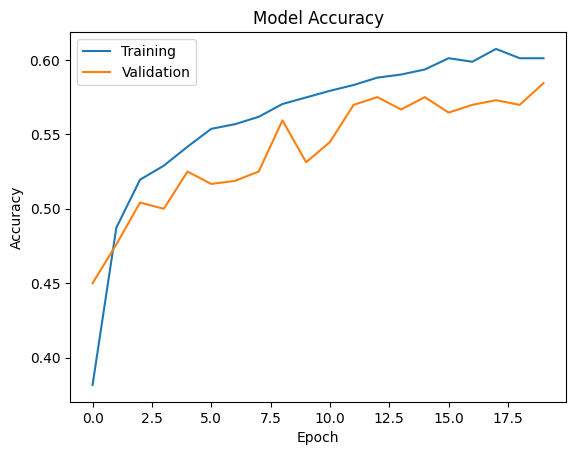

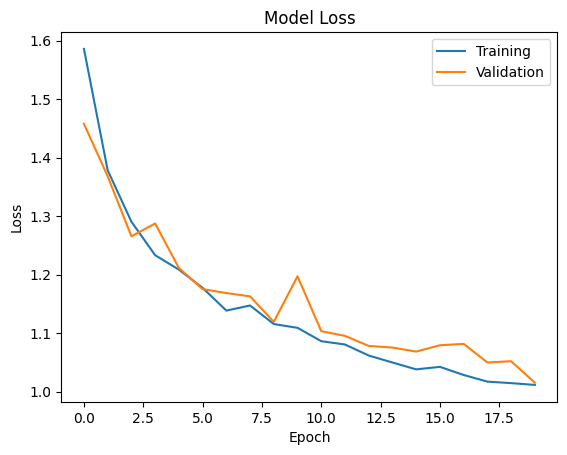

In [33]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [34]:
model.save('skin_cancer_classifier_undersampling.h5')